First we will load a 100 images to test the preprocessing speed

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import skimage
import glob 
import os 
import random
import numpy as np
import pandas as pd
from PIL import ImageFile
from sklearn.model_selection import train_test_split

#what is the role of truncated images?
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Sequential, models
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import efficientnet, vgg16
from keras.metrics import Recall

In [3]:
from google.colab import auth
auth.authenticate_user()


In [4]:
from google.cloud import storage

In [5]:
def download_blob(bucket_name, parent_blob: str):
    """Downloads a blob from the bucket."""
    #create client
    storage_client = storage.Client()

    #fetch blob
    blobs = storage_client.list_blobs(bucket_name)

    #make host directory if it doesn't exist
    if not os.path.isdir(parent_blob):
        os.mkdir(parent_blob)

    for blob in blobs:
        #where I want it stored!
        blob.download_to_filename(blob.name)
    return True

In [6]:
import zipfile

def extract_to(parent_blob):
    ##Unzips all files in our parent blob we just downloaded from GCS
    for zipped_file in os.listdir(parent_blob):
        print(f"Unzipping {zipped_file}...")
        with zipfile.ZipFile(os.path.join(parent_blob, zipped_file),
                             'r') as zip_ref:
            #we do not define an extraction directory since the zipped files already contain
            #the directories, since there was a large folder containing
            #all subsequent folders with files belonging to each category
            zip_ref.extractall()
        print("Success!")


In [7]:
download_blob("waves_surfer_data","zipped_waves")

extract_to("zipped_waves")


Unzipping Good.zip...
Success!
Unzipping Chaotic.zip...
Success!
Unzipping Flat.zip...
Success!


The preprocessing below works. It has been commented out to replace it with a better one. 

In [ ]:
# def preprocess_image(image):
#     resized = cv.resize(image,(300,300),interpolation = cv.INTER_AREA)
#     img = cv.medianBlur(resized,5)
#     ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
#     th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
#             cv.THRESH_BINARY,11,2)
#     th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv.THRESH_BINARY,15,2)
#     images = [th1, th2, th3, img]

    
#     return images
    

In [ ]:
"""def preprocess_image_improved(image,reshape_size):
    if image.shape == (570, 1015, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[250:-100,100:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,50)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,13,3)
        (T, thresh1) = cv.threshold(resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    elif image.shape == (582, 1034, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[60:500,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,50)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,13,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    elif image.shape == (624, 1200, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[150:,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,100,100)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    #EL PORTO IMAGES FOR GOOD ARE FAILING SYSTEMATICALLY
    elif image.shape == (624, 1110, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[350:-100,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,250)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,9,5)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/250
        images[1] = images[1]/250
    
        return images
    
    
    #WE HAVE THROWN ALL OF THOSE IN HERE FOR NOW  
    else:
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[150:,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,100,100)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        
        return images"""

The below preprocessing function is made for VGG16 model

In [3]:
def preprocess_image_improved(image):
    if image.shape == (570, 1015):
        cropped = image[250:-100,100:]
    elif image.shape == (582, 1034):
        cropped = image[60:500,:]
    elif image.shape == (624, 1200):
        cropped = image[150:,:]
    elif image.shape == (624, 1110):
        cropped = image[350:-100,:]
    else:
        cropped = image[150:,:]
        
    img = cv.resize(cropped,(300,300),interpolation = cv.INTER_AREA)
    img = cv.medianBlur(img,5)
    ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
    th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY,11,2)
#     th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv.THRESH_BINARY,15,2)
    images =[th1,img,th2]
    
    return images

In [5]:
X = []
y = []
idx = 0
failed =[]

for root , dirs , files in os.walk("raw_data"):
    if dirs:
        parent = root
        folders = dirs
        print(folders)

    if files:
        print(f"Preprocessing folder {folders[idx]}...")
        failed = [] 
        for file in np.random.choice(np.array(files),len(files), replace = False):
            try:
                original_image = cv.imread(os.path.join(parent , folders[idx], file), 0)
                
                     
                processed_image = preprocess_image_improved(original_image)
                
                if len(processed_image) < 2:
                    print(f"problemita in {os.path.join(parent , folders[idx], file)}")
                else:
                    X.append(np.array(processed_image).T)
                    y.append(idx)
                #The print below was just to check the value for each situation
                #print(idx)
            
            except Exception as e:
                 print("Detected bad image!")
                 failed.append(os.path.join(parent , folders[idx], file))
                 continue
        
        idx += 1
        
X = np.array(X)
y = np.array(y)
X.shape , y.shape

['Chaotic', 'Good', 'Flat']
Preprocessing folder Chaotic...
Preprocessing folder Good...
Preprocessing folder Flat...


((522, 300, 300, 3), (522,))

The code below is a clue from Nicole about what can we do to fix X shape.

Let's augment the little data we have. Considering the nature of the data heavy rotations are not advised.

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     featurewise_center = False,
#     featurewise_std_normalization = False,
#     rotation_range = 10,
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     horizontal_flip = True,
#     zoom_range = (0.8, 1.2),
#     #I added brightness changes, I think they are relevant to our task
#     brightness_range =(0.5,1)
#     ) 

: 

: 

: 

In [6]:
X.shape

(522, 300, 300, 3)

In [7]:
y_cat = to_categorical(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20)

This is the moment when we try Transfer Learning!

In [9]:
recall = Recall()

def compile_model(model, learning_rate=1e-4):
    model.compile(loss = "categorical_crossentropy",
                            optimizer = Adam(learning_rate=learning_rate),
                            metrics = ["accuracy"])
    return model

In [151]:
def initialize_vgg():
    n_classes = 3
    model = models.Sequential()
    model.add(vgg16.VGG16(weights="imagenet",
                    include_top=False,
                    input_shape= (300, 300, 3),
                    classes = n_classes))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(n_classes, activation = "softmax"))
    model.layers[0].trainable = False
    return model

In [155]:
model2 = initialize_vgg()
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_13  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_25 (Flatten)        (None, 512)               0         
                                                                 
 batch_normalization_78 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dropout_39 (Dropout)        (None, 256)             

In [156]:
model2 = compile_model(model2)

In [157]:
es = EarlyStopping(monitor = 'val_recall_3', 
                   mode = 'max', 
                   patience = 10, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model2.fit(X_train, y_train,
                             validation_split = 0.2,
                             batch_size = 16, 
                             epochs = 40, 
                             callbacks=[es])

Epoch 1/40
21/21 [==============================] - 6s 209ms/step - loss: 1.4040 - recall_3: 0.4039 - val_loss: 1.2029 - val_recall_3: 0.3333
Epoch 2/40
21/21 [==============================] - 4s 188ms/step - loss: 1.2900 - recall_3: 0.3844 - val_loss: 1.1269 - val_recall_3: 0.4167
Epoch 3/40
21/21 [==============================] - 4s 190ms/step - loss: 1.1031 - recall_3: 0.4655 - val_loss: 1.0731 - val_recall_3: 0.4286
Epoch 4/40
21/21 [==============================] - 4s 190ms/step - loss: 1.0202 - recall_3: 0.5255 - val_loss: 1.0255 - val_recall_3: 0.4405
Epoch 5/40
21/21 [==============================] - 4s 191ms/step - loss: 0.8619 - recall_3: 0.5676 - val_loss: 0.9982 - val_recall_3: 0.4643
Epoch 6/40
21/21 [==============================] - 4s 193ms/step - loss: 0.9468 - recall_3: 0.5586 - val_loss: 0.9693 - val_recall_3: 0.4762
Epoch 7/40
21/21 [==============================] - 4s 193ms/step - loss: 0.8426 - recall_3: 0.5856 - val_loss: 0.9470 - val_recall_3: 0.5000
Epoch 

In [158]:
model2.evaluate(X_test, y_test)

4/4 [==============================] - 1s 229ms/step - loss: 0.8732 - recall_3: 0.6286


[0.8731902241706848, 0.6285714507102966]

ResearchNet B7 model

In [26]:
def initialize_efficientnet():
    n_classes = 3
    model = models.Sequential()
    model.add(
        efficientnet.EfficientNetB7(weights = 'imagenet',
                                     include_top = False,
                                     classes = n_classes,
                                     input_shape = (300, 300, 3))
    )
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(n_classes, activation = "softmax"))
    model.layers[0].trainable = False
    return model
    

In [30]:
model = initialize_efficientnet()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 10, 10, 2560)     64097687  
                                                                 
 global_average_pooling2d_3   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               655616    
                                                                 
 dropout_6 (Dropout)         (None, 256)              

In [31]:
model = compile_model(model)

In [32]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 15, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                             validation_split = 0.2,
                             batch_size = 16, 
                             epochs = 60, 
                             callbacks=[es])

Epoch 1/60
21/21 [==============================] - 34s 691ms/step - loss: 1.4144 - accuracy: 0.4264 - val_loss: 1.0135 - val_accuracy: 0.6071
Epoch 2/60
21/21 [==============================] - 9s 441ms/step - loss: 1.1494 - accuracy: 0.5315 - val_loss: 0.9698 - val_accuracy: 0.6786
Epoch 3/60
21/21 [==============================] - 9s 425ms/step - loss: 0.9884 - accuracy: 0.5946 - val_loss: 0.9405 - val_accuracy: 0.6667
Epoch 4/60
21/21 [==============================] - 10s 467ms/step - loss: 0.8622 - accuracy: 0.6486 - val_loss: 0.9114 - val_accuracy: 0.5952
Epoch 5/60
21/21 [==============================] - 9s 427ms/step - loss: 0.7769 - accuracy: 0.6306 - val_loss: 0.8783 - val_accuracy: 0.6548
Epoch 6/60
21/21 [==============================] - 10s 487ms/step - loss: 0.7459 - accuracy: 0.6847 - val_loss: 0.8426 - val_accuracy: 0.6905
Epoch 7/60
21/21 [==============================] - 9s 429ms/step - loss: 0.6893 - accuracy: 0.7357 - val_loss: 0.8124 - val_accuracy: 0.6667
Epo

In [33]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 494ms/step - loss: 0.6931 - accuracy: 0.6857


[0.6930758953094482, 0.6857143044471741]

In [34]:
test_image  = cv.imread("/content/sample_data/flat1.png", 0)
test_image2  = cv.imread("/content/sample_data/flat2.png", 0)


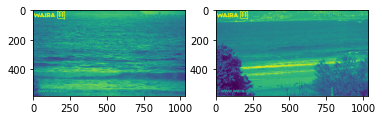

In [35]:
plt.subplot(1,2,1)
plt.imshow(test_image)

plt.subplot(1,2,2)
plt.imshow(test_image2)

In [36]:
test_image = preprocess_image_improved(test_image)
test_image = np.array([(test_image)])
test_image = test_image.reshape(1,300,300,3)